<a href="https://colab.research.google.com/github/jsalafica/Data-Science-II/blob/master/DSII_Entrega_Final_Javier_Salafica.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1) Imports + configuración

In [3]:
import os, json, numpy as np, pandas as pd, matplotlib.pyplot as plt
from joblib import dump

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score, ConfusionMatrixDisplay
from sklearn.inspection import permutation_importance

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier

RANDOM_STATE = 42
OUTPUT_DIR = "/content/outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)

DATA_PATH = "https://raw.githubusercontent.com/jsalafica/Data-Science-II/master/NYC_Accidents_2020.csv"
TARGET = "injury_flag"


## 2) cargar dataset + chequeo rápido

In [4]:
df = pd.read_csv(DATA_PATH)
print(df.shape)
df.head(3)


(74881, 29)


,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,...,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5
0,2020-08-29,15:40:00,BRONX,10466.0,40.8921,-73.833760,POINT (-73.83376 40.8921),PRATT AVENUE,STRANG AVENUE,NaN,...,Unspecified,NaN,NaN,NaN,4342908,Sedan,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN
1,2020-08-29,21:00:00,BROOKLYN,11221.0,40.6905,-73.919914,POINT (-73.919914 40.6905),BUSHWICK AVENUE,PALMETTO STREET,NaN,...,Unspecified,NaN,NaN,NaN,4343555,Sedan,Sedan,NaN,NaN,NaN
2,2020-08-29,18:20:00,NaN,NaN,40.8165,-73.946556,POINT (-73.946556 40.8165),8 AVENUE,NaN,NaN,...,NaN,NaN,NaN,NaN,4343142,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,NaN


## 3) crear target (binario): hubo heridos (>=1)

In [5]:
assert "NUMBER OF PERSONS INJURED" in df.columns, "No encuentro la columna 'NUMBER OF PERSONS INJURED'"
df[TARGET] = (df["NUMBER OF PERSONS INJURED"] > 0).astype(int)

# balance de clases
bal = df[TARGET].value_counts().rename(index={0:"No injuries (0)",1:"Injuries (1)"})
bal_pct = (df[TARGET].value_counts(normalize=True)*100).round(2).rename(index={0:"No injuries (0)",1:"Injuries (1)"})
display(pd.concat([bal, bal_pct], axis=1).set_axis(["count","percent"], axis=1))


,count,percent
injury_flag,,
No injuries (0),54460,72.73
Injuries (1),20421,27.27


## 4) EDA breve (nulls, dtypes, ejemplo de gráficos)

In [6]:
print("Filas/columnas:", df.shape)
print("\nTop NA:")
display(df.isna().sum().sort_values(ascending=False).head(12))

print("\nDtypes (muestra):")
display(df.dtypes.head(15))

# Histograma de hora (lo creamos en el paso 5; si aún no existe, no corras este plot)


Filas/columnas: (74881, 30)

Top NA:


,0
VEHICLE TYPE CODE 5,74378
CONTRIBUTING FACTOR VEHICLE 5,74358
VEHICLE TYPE CODE 4,73110
CONTRIBUTING FACTOR VEHICLE 4,73030
VEHICLE TYPE CODE 3,68457
CONTRIBUTING FACTOR VEHICLE 3,68116
OFF STREET NAME,55444
CROSS STREET NAME,39200
ZIP CODE,25747
BOROUGH,25741



Dtypes (muestra):


,0
CRASH DATE,object
CRASH TIME,object
BOROUGH,object
ZIP CODE,float64
LATITUDE,float64
LONGITUDE,float64
LOCATION,object
ON STREET NAME,object
CROSS STREET NAME,object
OFF STREET NAME,object


## 5) ingeniería de atributos mínima

NUM_COLS: ['HOUR', 'ZIP CODE', 'LATITUDE', 'LONGITUDE']
CAT_COLS: ['BOROUGH', 'VEHICLE TYPE CODE 1', 'CONTRIBUTING FACTOR VEHICLE 1']


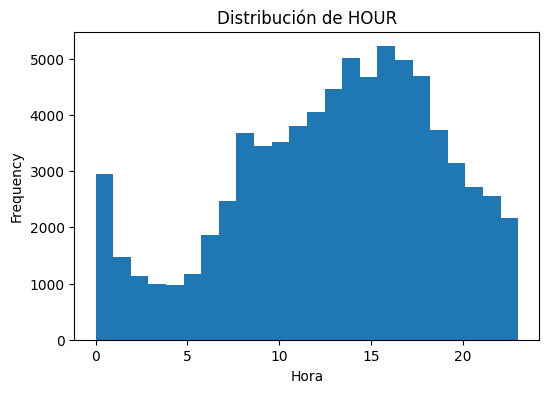

In [7]:
# HOUR a partir de CRASH TIME
def parse_hour(t):
    try:
        return int(str(t).split(":")[0])
    except Exception:
        return np.nan

if "CRASH TIME" in df.columns:
    df["HOUR"] = df["CRASH TIME"].apply(parse_hour)

# features que vamos a usar (ajustables)
NUM_COLS = [c for c in ["HOUR","ZIP CODE","LATITUDE","LONGITUDE"] if c in df.columns]
CAT_COLS = [c for c in ["BOROUGH","VEHICLE TYPE CODE 1","CONTRIBUTING FACTOR VEHICLE 1"] if c in df.columns]
TEXT_COLS = []   # no usamos texto acá

print("NUM_COLS:", NUM_COLS)
print("CAT_COLS:", CAT_COLS)

# gráfico simple de HOUR si existe
if "HOUR" in df.columns:
    df["HOUR"].dropna().astype(int).plot(kind="hist", bins=24, figsize=(6,4), title="Distribución de HOUR")
    plt.xlabel("Hora")
    plt.show()


## 6) split train/test estratificado

In [8]:
X = df[NUM_COLS + CAT_COLS + TEXT_COLS].copy()
y = df[TARGET].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=RANDOM_STATE, stratify=y
)

X_train.shape, X_test.shape


((59904, 7), (14977, 7))

## 7) preprocesamiento (ColumnTransformer)

In [12]:
# 7) preprocesamiento (ColumnTransformer) - versión liviana
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

numeric_pipe = make_pipeline(
    SimpleImputer(strategy="median"),
    StandardScaler()
)

# min_frequency agrupa categorías muy raras en 'infrequent_sklearn' y baja mucho la dimensionalidad
categorical_pipe = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore", min_frequency=0.01, sparse_output=True)
)

transformers = []
if NUM_COLS: transformers.append(("num", numeric_pipe, NUM_COLS))
if CAT_COLS: transformers.append(("cat", categorical_pipe, CAT_COLS))

preprocessor = ColumnTransformer(transformers=transformers, remainder="drop", sparse_threshold=0.3)
preprocessor



ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['HOUR', 'ZIP CODE', 'LATITUDE', 'LONGITUDE']),
                                ('cat',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                min_frequency=0.01))]),
                                 ['BOROUGH', 'VEHICLE TYPE CODE 1',
                                  'CONTRIBUTING FACTOR VEHICLE 1'])])

## 8) modelos + grillas de hiperparámetros

In [13]:
# 8) modelos + grillas de hiperparámetros (más chica)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

models = {
    "lr": (LogisticRegression(max_iter=1000), {
        "clf__C": [0.5, 1.0, 3.0],
        "clf__penalty": ["l2"],
        "clf__solver": ["lbfgs"],
        "clf__class_weight": [None, "balanced"]
    }),
    "rf": (RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1), {
        "clf__n_estimators": [150, 300],
        "clf__max_depth": [None, 12],
        "clf__min_samples_split": [2, 5],
        "clf__min_samples_leaf": [1, 2],
        "clf__class_weight": ["balanced"]  # fijamos balanced
    }),
    "hgb": (HistGradientBoostingClassifier(random_state=RANDOM_STATE), {
        "clf__learning_rate": [0.05, 0.1],
        "clf__max_depth": [None, 6],
        "clf__max_iter": [200, 300],
    })
}



## 9) función de entrenamiento + selección (con GridSearchCV y F1 macro)

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

def train_and_select(model_key: str, scoring="f1_macro", use_subsample=True, subsample_frac=0.5):
    assert model_key in models, f"Modelo desconocido: {model_key}"
    clf, param_grid = models[model_key]

    pipe = Pipeline([
        ("prep", preprocessor),
        ("clf", clf)
    ])

    # ---- Subsample para la BUSQUEDA (acelera y baja memoria) ----
    if use_subsample:
        X_sub = X_train.sample(frac=subsample_frac, random_state=RANDOM_STATE)
        y_sub = y_train.loc[X_sub.index]
    else:
        X_sub, y_sub = X_train, y_train

    # MUY IMPORTANTE:
    # n_jobs=1 aquí para evitar "paralelismo anidado" (RF ya usa n_jobs internos)
    gs = GridSearchCV(
        estimator=pipe,
        param_grid=param_grid,
        scoring=scoring,
        cv=cv,
        n_jobs=1,
        refit=True,
        verbose=2
    )
    gs.fit(X_sub, y_sub)
    print("Mejores hiperparámetros (subsample):", gs.best_params_)

    # Re-entrenamos el MEJOR pipeline en TODO el train
    best = gs.best_estimator_
    best.fit(X_train, y_train)
    return best

# entrená al menos dos (LogReg y RandomForest)
best_lr = train_and_select("lr", use_subsample=True, subsample_frac=0.5)
best_rf = train_and_select("rf", use_subsample=True, subsample_frac=0.5)



Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END clf__C=0.5, clf__class_weight=None, clf__penalty=l2, clf__solver=lbfgs; total time=   0.4s
[CV] END clf__C=0.5, clf__class_weight=None, clf__penalty=l2, clf__solver=lbfgs; total time=   0.5s
[CV] END clf__C=0.5, clf__class_weight=None, clf__penalty=l2, clf__solver=lbfgs; total time=   0.3s
[CV] END clf__C=0.5, clf__class_weight=None, clf__penalty=l2, clf__solver=lbfgs; total time=   0.5s
[CV] END clf__C=0.5, clf__class_weight=None, clf__penalty=l2, clf__solver=lbfgs; total time=   0.5s
[CV] END clf__C=0.5, clf__class_weight=balanced, clf__penalty=l2, clf__solver=lbfgs; total time=   0.5s
[CV] END clf__C=0.5, clf__class_weight=balanced, clf__penalty=l2, clf__solver=lbfgs; total time=   0.4s
[CV] END clf__C=0.5, clf__class_weight=balanced, clf__penalty=l2, clf__solver=lbfgs; total time=   0.4s
[CV] END clf__C=0.5, clf__class_weight=balanced, clf__penalty=l2, clf__solver=lbfgs; total time=   0.4s
[CV] END clf__C=0.5, clf

## 10) evaluación (reporte, CM, ROC/PR si aplica)

In [ ]:
def evaluate(model, X_test, y_test, labels=None, prefix="model"):
    y_pred = model.predict(X_test)
    print("Classification report:")
    print(classification_report(y_test, y_pred))

    # CM
    cm = confusion_matrix(y_test, y_pred, labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels if labels is not None else None)
    plt.figure(figsize=(5,5))
    disp.plot(xticks_rotation=45)
    plt.title(f"Matriz de Confusión - {prefix}")
    plt.tight_layout()
    plt.show()

    # ROC & PR si binario y hay proba o decision_function
    roc_auc = None; pr_auc = None
    proba_supported = hasattr(model, "predict_proba") or hasattr(model, "decision_function")
    if proba_supported and y_test.nunique() == 2:
        if hasattr(model, "predict_proba"):
            y_score = model.predict_proba(X_test)[:, 1]
        else:
            y_score = model.decision_function(X_test)

        fpr, tpr, _ = roc_curve(y_test, y_score, pos_label=1)
        roc_auc = roc_auc_score(y_test, y_score)
        plt.figure(figsize=(5,4))
        plt.plot(fpr, tpr, label=f"ROC-AUC = {roc_auc:.3f}")
        plt.plot([0,1],[0,1], linestyle="--")
        plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title(f"ROC - {prefix}"); plt.legend(); plt.show()

        precision, recall, _ = precision_recall_curve(y_test, y_score, pos_label=1)
        pr_auc = average_precision_score(y_test, y_score)
        plt.figure(figsize=(5,4))
        plt.plot(recall, precision, label=f"PR-AUC = {pr_auc:.3f}")
        plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title(f"Precision-Recall - {prefix}"); plt.legend(); plt.show()

    return {"roc_auc": roc_auc, "pr_auc": pr_auc}

metrics_lr = evaluate(gs_lr.best_estimator_, X_test, y_test, prefix="LogisticRegression")
metrics_rf = evaluate(gs_rf.best_estimator_, X_test, y_test, prefix="RandomForest")
metrics_lr, metrics_rf


## 11) permutation importance (interpretabilidad)

In [ ]:
def permutation_importance_df(model, X_test, y_test, n_repeats=10):
    result = permutation_importance(model, X_test, y_test, n_repeats=n_repeats, random_state=RANDOM_STATE, n_jobs=-1)
    # intentar obtener nombres de features después del preprocesamiento
    try:
        prep = model.named_steps["prep"]
        feat_names = []
        for name, trans, cols in prep.transformers_:
            if name == "num":
                feat_names += cols
            elif name == "cat":
                # OneHotEncoder expande; usamos get_feature_names_out
                ohe = trans.named_steps["onehotencoder"]
                cats = ohe.get_feature_names_out(cols).tolist()
                feat_names += cats
    except Exception:
        feat_names = [f"f{i}" for i in range(len(result.importances_mean))]

    imp = pd.DataFrame({
        "feature": feat_names,
        "importance_mean": result.importances_mean,
        "importance_std": result.importances_std
    }).sort_values("importance_mean", ascending=False)

    imp.head(20).plot(kind="barh", x="feature", y="importance_mean", figsize=(7,6), title="Permutation Importance (Top 20)")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

    return imp

imp_rf = permutation_importance_df(gs_rf.best_estimator_, X_test, y_test)
imp_rf.head(10)


## 12) guardar artefactos (modelo ganador + reporte)

In [ ]:
# elegí el mejor según tu métrica principal (ej: F1 macro o ROC-AUC)
best_model = gs_rf.best_estimator_   # si te gustó más RF; si no, probá gs_lr.best_estimator_

model_path = os.path.join(OUTPUT_DIR, "best_model.joblib")
dump(best_model, model_path)

report = {
    "best_model": "RandomForest",
    "best_params": gs_rf.best_params_,
    "metrics_lr": metrics_lr,
    "metrics_rf": metrics_rf,
    "features_numeric": NUM_COLS,
    "features_categorical": CAT_COLS,
    "target": TARGET
}
with open(os.path.join(OUTPUT_DIR, "metrics_report.json"), "w", encoding="utf-8") as f:
    json.dump(report, f, indent=2, ensure_ascii=False)

model_path, os.path.join(OUTPUT_DIR, "metrics_report.json")
